In [29]:
import matplotlib.pyplot as plt
import pickle
import os
import math
import numpy as np
from od.social import SocialGroup
from od.network.types import ResourceAllocatorType,BaseStationType
from od.misc.interest import InterestConfig
from numpy import random
plt.rcParams.update(
    {
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "legend.loc":"upper left",
    "legend.framealpha":0.3,
    "font.size":14,
    }
)

In [30]:
def GetLineMarkerStyle(line_no):
    line_style = ['--','-.',':']
    marker_style = ['o','v','^','<','>','s','p','*','h','H','x','D']
    line_no = line_no % (len(line_style)*len(marker_style))
    return marker_style[int(line_no%len(marker_style))] + line_style[int(line_no/(len(marker_style)))]
#     return marker_style[int(line_no/len(line_style))] + line_style[int(line_no%(len(line_style)))]

In [31]:
sg_graph_configs = [
    {
        "catalog": "veh_recv_intact_appdata_trip",
        "topic": "End-to-End Time",
#         "x": "Maximum Data Generated Per Second(Unique Distribution) ",
        "x": "Traffic Scale",
        "y": "Time(ms)",
        "subject": ["Avg", "Max", "Min"]
    },
    {
        "catalog": "bs_appdata_txq_wait",
        "topic": "Wait Time in Downlink Queue",
        "x": "Traffic Scale",
        "y": "Time(ms)",
        "subject": ["Avg", "Max", "Min"]
    },
    {
        "catalog": "bs_appdata_tx",
        "topic": "Transfer Time",
        "x": "Traffic Scale",
        "y": "Time(ms)",
        "subject": ["Avg", "Max", "Min"]
    },
]


In [32]:
nsg_graph_configs = [
    {
        "catalog": "bs_through_put",
        "topic": "Throughput",
        "x": "Traffic Scale",
        "y": "Megabits",
        "subject": [bs_type for bs_type in BaseStationType]
    },
    
]


In [33]:
bs_sg_graph_configs = [
    {
        "catalog": "bs_sg_res_use_rate",
        "topic": "Social-Group Traffic Service Ratio",
        "x": "Traffic Scale",
        "y": "%",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]



In [34]:
sys_graph_configs = [
    {
        "catalog": "sys_through_put",
        "topic": "Throughput",
        "x": "Traffic Scale",
        "y": "Megabits",
    },
]

In [35]:
bs_names = {
    BaseStationType.UMA: "4G-eNB",
    BaseStationType.UMI: "5G-gNB",
}

In [36]:
def ExtractAbbreviations(abbrev):
    if(abbrev == "Avg"):
        return "Average"
    elif(abbrev == "Max"):
        return "Maximum"
    elif(abbrev == "Min"):
        return "Minimum"

In [37]:
def BaseStationScenario(with_rsu):
    if(with_rsu):
        return "4G+5G"
    else:
        return  "4G"

In [38]:
s = [13232421, 102948123, 4419883, 5157253,1,2,3,4,5,6,7,8]
a = [t for t in ResourceAllocatorType]
b = [False, True]
c = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [39]:
interest_config = InterestConfig(None, False, 0)
stats = [[[[None for _c in c] for _b in b] for _a in a]for _s in s]
for _s , seed in enumerate(s):
    for _a, res_alloc_type in enumerate(a):
        for _b, req_rsu in enumerate(b):
            for _c, traffic_scale in enumerate(c):
                interest_config.res_alloc_type = res_alloc_type
                interest_config.req_rsu = req_rsu
                interest_config.traffic_scale = traffic_scale
                try:
                    with open("data/{}/{}/report.pickle".format(seed,str(interest_config)), "rb") as file:
                        stats[_s][_a][_b][_c] = pickle.load(file)
                except:
                    print(str(interest_config) + " seed({})".format(seed))

In [40]:
# create picture folder
dirpath = "pics/"
if not os.path.isdir(dirpath):
    os.mkdir(dirpath)

In [41]:
# for subject in subjects:
#     print(subject)
#     for _b in range(len(b)):
#         for _a in range(len(a)):
#             for sg in SocialGroup:
#                 for _c in range(len(c)):
#                     for _s in range(len(s)):
#                         v = stats[_s][_a][_b][_c][catalog][sg][subject.lower()]
#                         if v == _pinf or v == _ninf:
#                             v = 0
#                         if(c[_c] == 0.7):
#                             print("seed:{},{},rsu:{},scale:{},sg:{},value:{}".format(s[_s],a[_a].name,b[_b],c[_c],sg,v*1000))
          


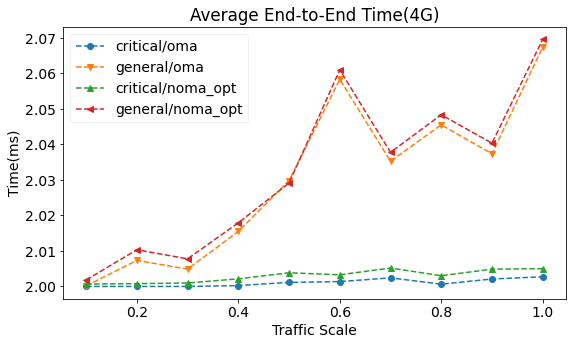

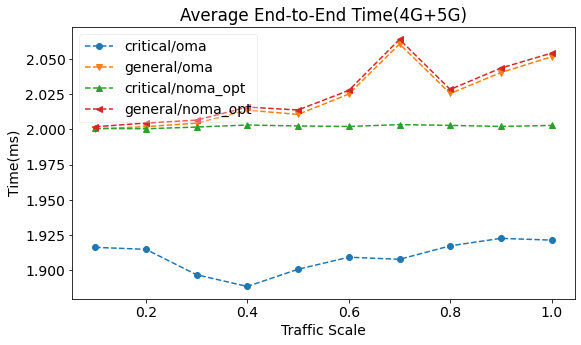

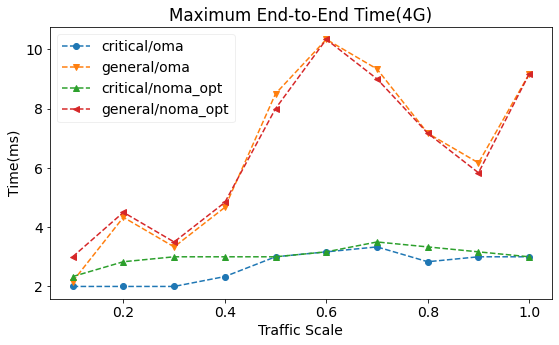

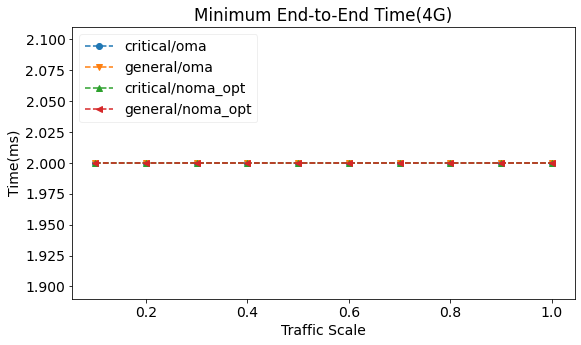

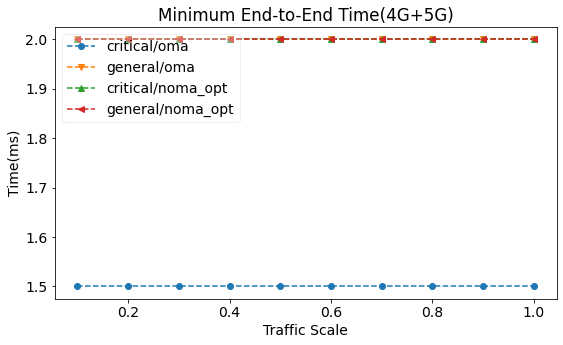

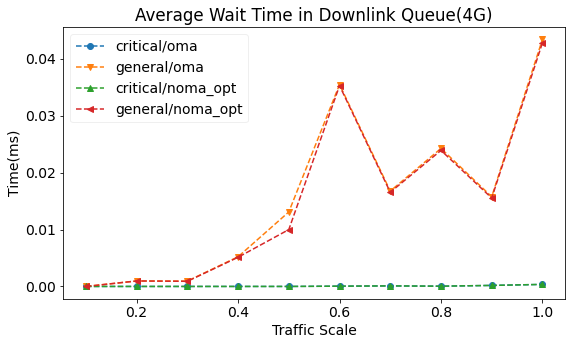

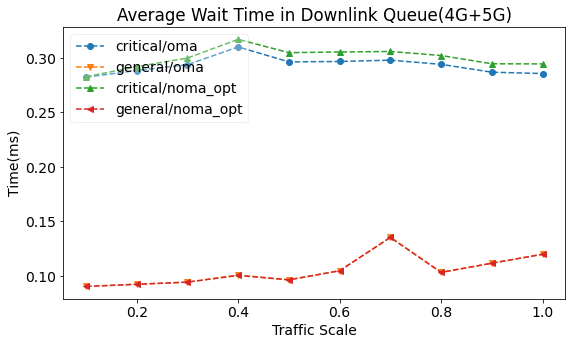

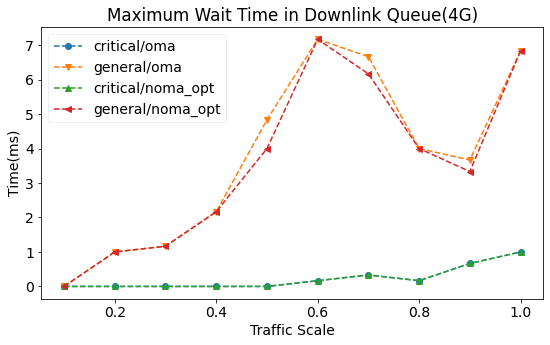

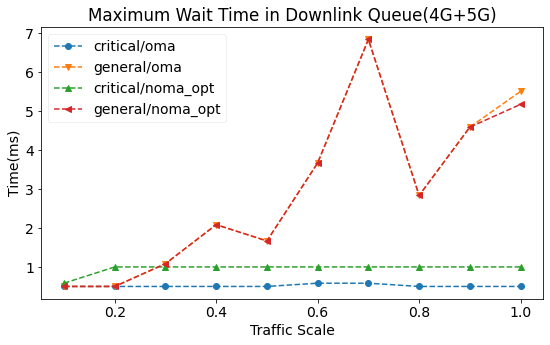

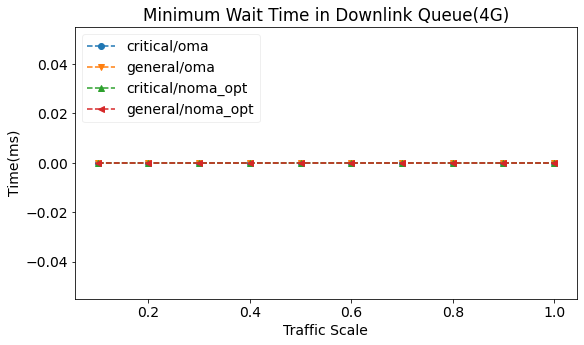

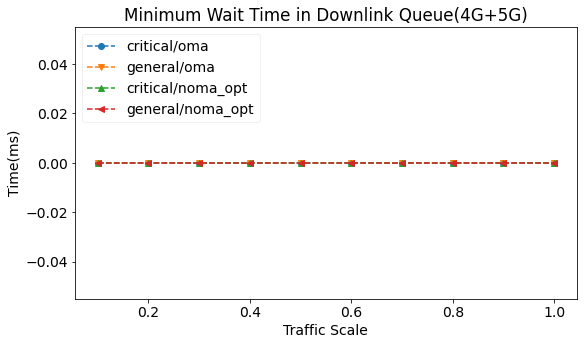

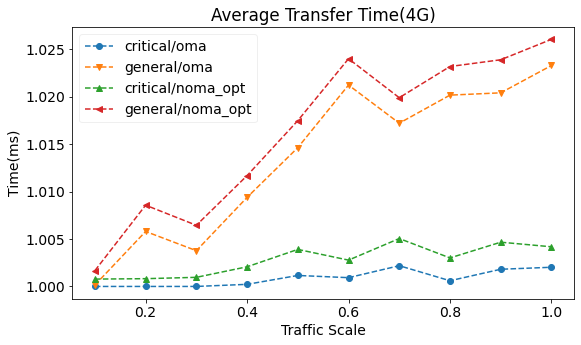

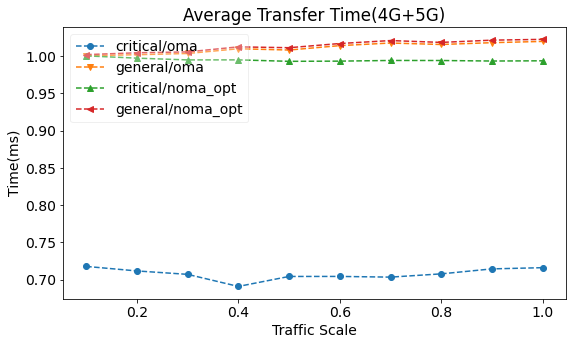

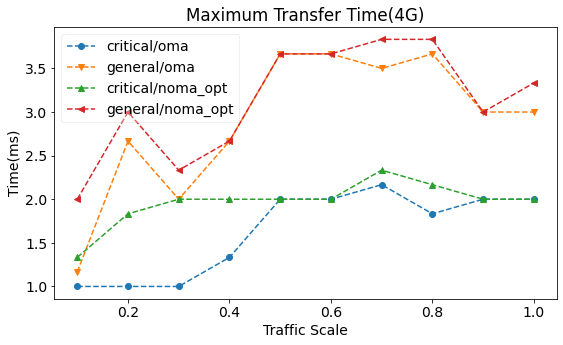

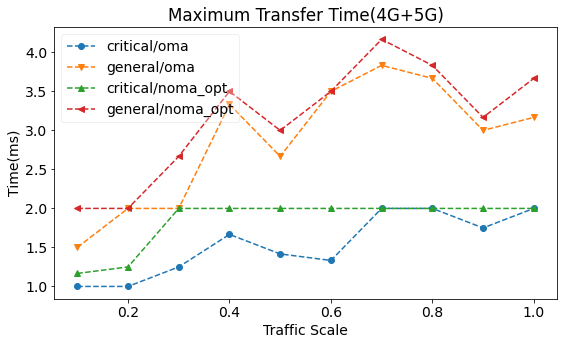

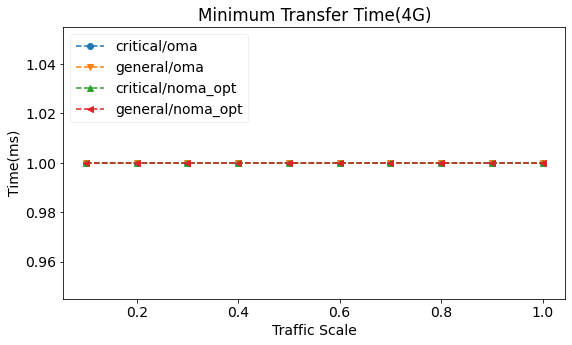

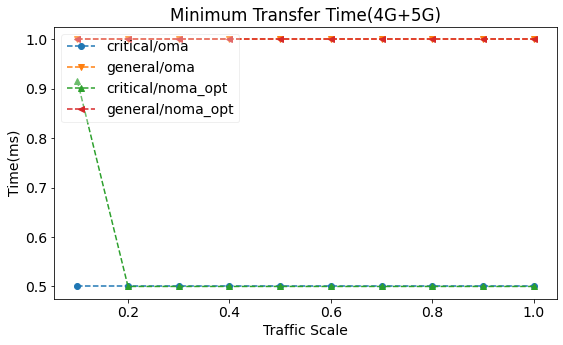

In [42]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in sg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for _b in range(len(b)):
            title = "{} {}({})".format(
                ExtractAbbreviations(subject), 
                topic,
                BaseStationScenario(b[_b])
            )
            plt.figure(serial, figsize=(9, 5))
            plt.xlabel(config["x"])
            plt.ylabel(config["y"])
            plt.title(title)
            line_no = 0
            for _a in range(len(a)):
                for sg in SocialGroup:
                    y = []
                    x = c
                    for _c in range(len(c)):
                        value = []
                        for _s in range(len(s)):
                            v = stats[_s][_a][_b][_c][catalog][sg][subject.lower()]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*1000)
                        value.sort()
                        drop_elements= math.floor(math.floor(len(value)/2)/2)

                        y.append(sum(value[drop_elements:-drop_elements])/(len(s)-2*drop_elements))
                        # y.append(np.median(value))
                    plt.plot(
                        x,
                        y,
                        GetLineMarkerStyle(line_no),
                        label="{}/{}".format(
                              str(sg).lower(),
                              a[_a].name.lower(),
                        )
                    )
                    line_no += 1
            plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
            # plt.savefig('{}/{}.pdf'.format(dirpath, title))
            serial += 1
plt.show()


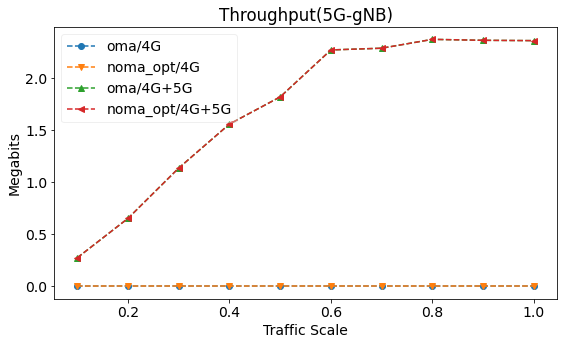

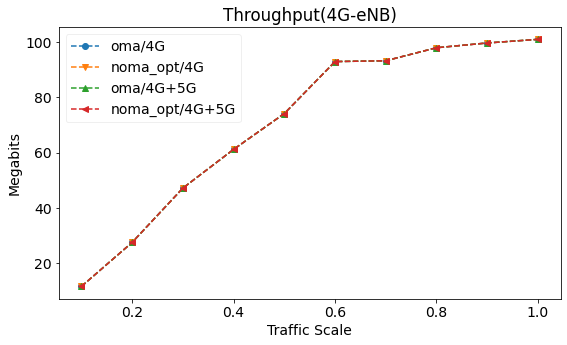

In [37]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in nsg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        title = "{}({})".format(
            topic, 
            bs_names[subject]
        )
        plt.figure(serial, figsize=(9, 5))
        plt.xlabel(config["x"])
        plt.ylabel(config["y"])
        plt.title(title)
        line_no = 0
        for _b in range(len(b)):
            for _a in range(len(a)):
                y = []
                x = c
                for _c in range(len(c)):
                    value = 0
                    for _s in range(len(s)):
                        v = stats[_s][_a][_b][_c][catalog][subject]
                        if v == _pinf or v == _ninf:
                            v = 0
                        value += v
                    
                    y.append((value/len(s))/10**6)
                plt.plot(
                    x,
                    y,
                    GetLineMarkerStyle(line_no),
                    label="{}/{}".format(
                        a[_a].name.lower(),
                        BaseStationScenario(b[_b])
                    )
                )
                line_no += 1
                #   plt.text(
                #     c[-1],
                #     y[-1],
                #   )
        plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
        plt.savefig('{}/{}.pdf'.format(dirpath, title))
        serial += 1
plt.show()


  rsu:False
  rsu:True
  rsu:False
  rsu:True


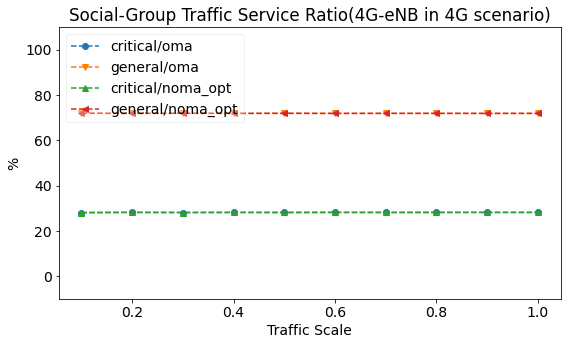

In [40]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1

for config in bs_sg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        # print("subject:{}".format(subject.name))
        for _b in range(len(b)):
            print("  rsu:{}".format(b[_b]))
            title = "{}({} in {} scenario)".format(
                    topic,
                    bs_names[subject],
                    BaseStationScenario(b[_b])
            )
            plt.figure(serial, figsize=(9, 5))
            plt.xlabel(config["x"])
            plt.ylabel(config["y"])
            plt.title(title)
            line_no = 0
            for _a in range(len(a)):
                # print("    alloc_type:{}".format(a[_a].name))
                for sg in SocialGroup:
                    # print("      sg:{}".format(sg))
                    y = []
                    x = c
                    for _c in range(len(c)):
                        # print("        scale:{}".format(c[_c]))
                        value = 0
                        for _s in range(len(s)):
                            v = stats[_s][_a][_b][_c][catalog][subject][sg]
                            # print("          seed:{} value:{}".format(s[_s],v))
                            if v == _pinf or v == _ninf:
                                v = 0
                            value += v
                        y.append(value/len(s) * 100)
                    plt.plot(
                        x,
                        y,
                        GetLineMarkerStyle(line_no),
                        label="{}/{}".format(
                              str(sg).lower(),
                              a[_a].name.lower(),
                        )
                    )
                    line_no += 1
                    #   plt.text(
                    #     c[-1],
                    #     y[-1],
                    #   )
            plt.ylim([-10,110])
            plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
            plt.savefig('{}/{}.pdf'.format(dirpath, title))
            serial += 1
plt.show()


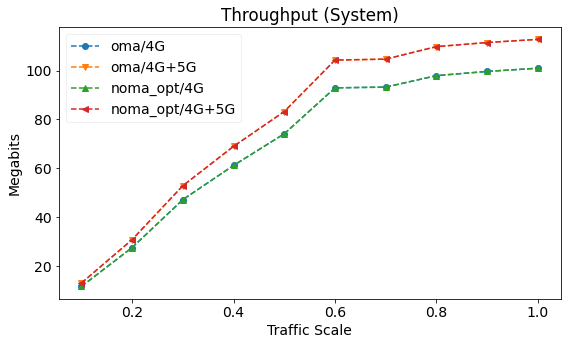

In [26]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1

for config in sys_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    title = "{} (System)".format(topic)
    plt.figure(serial, figsize=(9, 5))
    plt.xlabel(config["x"])
    plt.ylabel(config["y"])
    plt.title(title)
    line_no = 0
    for _a in range(len(a)):
        for _b in range(len(b)):
            y = []
            x = c
            for _c in range(len(c)):
                value = 0
                for _s in range(len(s)):
                    v = stats[_s][_a][_b][_c][catalog]
                    if v == _pinf or v == _ninf:
                        v = 0
                    value += v
                y.append(value/len(s)/10**6)
            plt.plot(
                x,
                y,
                GetLineMarkerStyle(line_no),
                label="{}/{}".format(
                    a[_a].name.lower(),
                    BaseStationScenario(b[_b])
                )
            )
            line_no += 1
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
    plt.savefig('{}/{}.pdf'.format(dirpath, title))
    serial += 1
plt.show()
